In [1]:
import os
import numpy as np
import pyedflib
from scipy.stats import zscore
from scipy.signal import stft
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ⚙️ 설정
root_dir = "/home/mhb0917/캡스톤디자인/sleep/recordings"
seq_len = 10
batch_size = 16
epochs = 50
learning_rate = 0.0001

label_map = {
    'Sleep stage W': 0,
    'Sleep stage N1': 1,
    'Sleep stage N2': 1,
    'Sleep stage N3': 2,
    'Sleep stage R': 3
}

In [2]:
# 1️⃣ 데이터 로드
def load_ecg_and_labels(sn_id, root_dir):
    base = f"SN{int(sn_id):03d}"
    ecg_path = os.path.join(root_dir, f"{base}.edf")
    label_path = os.path.join(root_dir, f"{base}_sleepscoring.edf")
    if not os.path.exists(ecg_path) or not os.path.exists(label_path):
        print(f"❌ 파일 없음: {base}")
        return [], []

    with pyedflib.EdfReader(ecg_path) as ecg_reader:
        ecg_signal = ecg_reader.readSignal(7)

    with pyedflib.EdfReader(label_path) as label_reader:
        onsets, durations, labels = label_reader.readAnnotations()

    segments, segment_labels = [], []
    for onset, duration, label in zip(onsets, durations, labels):
        label_str = label.decode() if isinstance(label, bytes) else label
        if label_str not in label_map:
            continue
        start = int(onset * 256)
        num_segments = int(duration // 30)
        for i in range(num_segments):
            seg_start = start + i * 7680
            seg_end = seg_start + 7680
            if seg_end > len(ecg_signal):
                break
            segment = zscore(ecg_signal[seg_start:seg_end])
            if np.isnan(segment).any():
                continue
            segments.append(segment.astype(np.float32))
            segment_labels.append(label_map[label_str])
    return segments, segment_labels

In [3]:
# 2️⃣ STFT 함수
def compute_stft(segment, fs=256, nperseg=256, noverlap=128):
    f, t, Zxx = stft(segment, fs=fs, nperseg=nperseg, noverlap=noverlap)
    # 로그 스케일 변환
    magnitude = 10 * np.log10(np.abs(Zxx) + 1e-8)
    return magnitude.T  # (time, freq)


In [4]:
# 3️⃣ STFT + 시퀀스 생성
def create_sequences_stft(segments, labels, seq_len=10):
    X, y = [], []
    for i in range(len(segments) - seq_len + 1):
        stft_seqs = []
        for seg in segments[i:i+seq_len]:
            stft_feat = compute_stft(seg)  # (time, freq)
            stft_seqs.append(stft_feat)  # (time, freq)
        X.append(np.stack(stft_seqs))  # (seq_len, time, freq)
        y.append(labels[i + seq_len - 1])
    return np.array(X), np.array(y)

def merge_data(data_dict):
    X_all, y_all = [], []
    for X, y in data_dict.values():
        if len(X) == 0:
            continue
        X_all.append(X)
        y_all.append(y)
    if len(X_all) == 0:
        return np.array([]), np.array([])
    return np.concatenate(X_all), np.concatenate(y_all)


In [5]:
# 4️⃣ Dataset
class SleepDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
# 5️⃣ CNN-STFT-LSTM 모델
class CNN_STFT_LSTM(nn.Module):
    def __init__(self, time_bins, freq_bins, cnn_out=64, lstm_hidden=128, num_classes=4):
        super(CNN_STFT_LSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, cnn_out, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(cnn_out),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # (batch*seq, channels, 1, 1)
        )
        self.lstm = nn.LSTM(input_size=cnn_out, hidden_size=lstm_hidden, num_layers=2, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, num_classes)

    def forward(self, x):
        batch_size, seq_len, time_bins, freq_bins = x.shape
        x = x.view(batch_size * seq_len, 1, time_bins, freq_bins)  # (batch*seq, 1, time, freq)
        x = self.cnn(x)  # (batch*seq, channels, 1, 1)
        x = x.view(batch_size, seq_len, -1)  # (batch, seq, channels)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

In [7]:
# 6️⃣ 학습 및 평가 함수
#def train_model(model, loader, epochs=10, lr=0.0001, device='cuda' if torch.cuda.is_available() else 'cpu'):
def train_model(model, loader, epochs=10, lr=0.0001, device='cuda'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (outputs.argmax(1) == y_batch).sum().item()
            total += y_batch.size(0)
        acc = correct / total if total > 0 else 0
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss:.4f} Acc: {acc:.4f}")

def evaluate_model(model, loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = outputs.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())
    print(classification_report(all_labels, all_preds, labels=[0,1,2,3], target_names=["W", "N1/2", "N3", "R"], zero_division=0))
    cm = confusion_matrix(all_labels, all_preds, labels=[0,1,2,3])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["W", "N1/2", "N3", "R"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

In [8]:
# 7️⃣ 데이터 로드 및 처리
train_X, train_y = [], []
val_data, test_data = {}, {}
for i in range(1, 155):
    segments, labels = load_ecg_and_labels(i, root_dir)
    if segments:
        X_seq, y_seq = create_sequences_stft(segments, labels, seq_len)
        if 1 <= i <= 93:
            train_X.append(X_seq)
            train_y.append(y_seq)
        elif 94 <= i <= 123:
            val_data[f"SN{i:03d}"] = (X_seq, y_seq)
        else:
            test_data[f"SN{i:03d}"] = (X_seq, y_seq)

train_X = np.concatenate(train_X)
train_y = np.concatenate(train_y)
time_bins, freq_bins = train_X.shape[2], train_X.shape[3]
print(f"✅ Train shape: {train_X.shape}, time={time_bins}, freq={freq_bins}")


❌ 파일 없음: SN014


❌ 파일 없음: SN064


❌ 파일 없음: SN135


✅ Train shape: (81795, 10, 61, 129), time=61, freq=129


In [9]:
# 8️⃣ 모델 학습
train_loader = DataLoader(SleepDataset(train_X, train_y), batch_size=batch_size, shuffle=True)
model = CNN_STFT_LSTM(time_bins, freq_bins)
train_model(model, train_loader, epochs=epochs, lr=learning_rate)

Epoch [1/50] Loss: 6104.0318 Acc: 0.5011


Epoch [2/50] Loss: 5805.9715 Acc: 0.5185


Epoch [3/50] Loss: 5637.7971 Acc: 0.5275


Epoch [4/50] Loss: 5512.3990 Acc: 0.5319


Epoch [5/50] Loss: 5397.6455 Acc: 0.5380


Epoch [6/50] Loss: 5308.0438 Acc: 0.5436


Epoch [7/50] Loss: 5217.6985 Acc: 0.5498


Epoch [8/50] Loss: 5132.4058 Acc: 0.5572


Epoch [9/50] Loss: 5044.4137 Acc: 0.5652


Epoch [10/50] Loss: 4938.1836 Acc: 0.5746


Epoch [11/50] Loss: 4868.5694 Acc: 0.5799


Epoch [12/50] Loss: 4768.4609 Acc: 0.5884


Epoch [13/50] Loss: 4686.3523 Acc: 0.5954


Epoch [14/50] Loss: 4602.6049 Acc: 0.6050


Epoch [15/50] Loss: 4527.3180 Acc: 0.6106


Epoch [16/50] Loss: 4433.3026 Acc: 0.6195


Epoch [17/50] Loss: 4366.1909 Acc: 0.6249


Epoch [18/50] Loss: 4301.1678 Acc: 0.6335


Epoch [19/50] Loss: 4224.4750 Acc: 0.6398


Epoch [20/50] Loss: 4167.4862 Acc: 0.6450


Epoch [21/50] Loss: 4087.5600 Acc: 0.6543


Epoch [22/50] Loss: 4020.2472 Acc: 0.6588


Epoch [23/50] Loss: 3964.2767 Acc: 0.6650


Epoch [24/50] Loss: 3902.2390 Acc: 0.6691


Epoch [25/50] Loss: 3858.2734 Acc: 0.6733


Epoch [26/50] Loss: 3802.0918 Acc: 0.6800


Epoch [27/50] Loss: 3731.8619 Acc: 0.6859


Epoch [28/50] Loss: 3684.6996 Acc: 0.6882


Epoch [29/50] Loss: 3631.0597 Acc: 0.6933


Epoch [30/50] Loss: 3592.5374 Acc: 0.6987


Epoch [31/50] Loss: 3544.7886 Acc: 0.7021


Epoch [32/50] Loss: 3491.7172 Acc: 0.7076


Epoch [33/50] Loss: 3437.8444 Acc: 0.7114


Epoch [34/50] Loss: 3399.5271 Acc: 0.7161


Epoch [35/50] Loss: 3358.0967 Acc: 0.7211


Epoch [36/50] Loss: 3314.5552 Acc: 0.7235


Epoch [37/50] Loss: 3276.3839 Acc: 0.7255


Epoch [38/50] Loss: 3236.8224 Acc: 0.7308


Epoch [39/50] Loss: 3197.1863 Acc: 0.7351


Epoch [40/50] Loss: 3147.4222 Acc: 0.7361


Epoch [41/50] Loss: 3121.1192 Acc: 0.7414


Epoch [42/50] Loss: 3085.9358 Acc: 0.7431


Epoch [43/50] Loss: 3040.6282 Acc: 0.7472


Epoch [44/50] Loss: 2999.8222 Acc: 0.7515


Epoch [45/50] Loss: 2969.3629 Acc: 0.7534


Epoch [46/50] Loss: 2939.8998 Acc: 0.7560


Epoch [47/50] Loss: 2889.1833 Acc: 0.7618


Epoch [48/50] Loss: 2862.2356 Acc: 0.7624


Epoch [49/50] Loss: 2834.9352 Acc: 0.7666


Epoch [50/50] Loss: 2792.7094 Acc: 0.7703



📊 Validation (전체) 평가


              precision    recall  f1-score   support

           W       0.37      0.52      0.43      4851
        N1/2       0.48      0.51      0.50     11507
          N3       0.39      0.27      0.32      5008
           R       0.30      0.22      0.26      3633

    accuracy                           0.42     24999
   macro avg       0.39      0.38      0.38     24999
weighted avg       0.42      0.42      0.41     24999



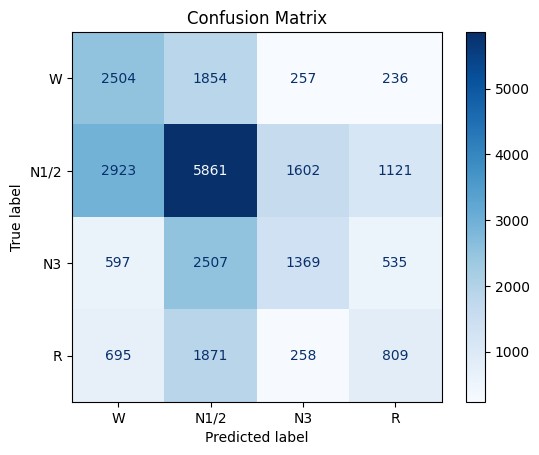


📊 Test (전체) 평가


              precision    recall  f1-score   support

           W       0.52      0.59      0.55      4228
        N1/2       0.55      0.57      0.56     13288
          N3       0.47      0.41      0.44      5803
           R       0.30      0.27      0.28      4280

    accuracy                           0.49     27599
   macro avg       0.46      0.46      0.46     27599
weighted avg       0.49      0.49      0.49     27599



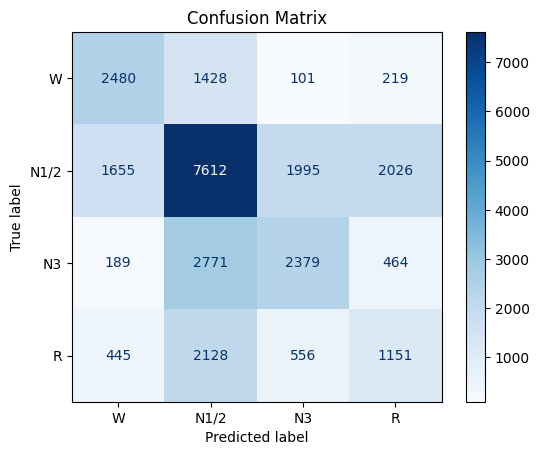

In [10]:
# 9️⃣ 전체 평가
X_val_all, y_val_all = merge_data(val_data)
if len(X_val_all) > 0:
    print("\n📊 Validation (전체) 평가")
    evaluate_model(model, DataLoader(SleepDataset(X_val_all, y_val_all), batch_size=batch_size, shuffle=False))

X_test_all, y_test_all = merge_data(test_data)
if len(X_test_all) > 0:
    print("\n📊 Test (전체) 평가")
    evaluate_model(model, DataLoader(SleepDataset(X_test_all, y_test_all), batch_size=batch_size, shuffle=False))